# Exploring Data from a Video Game Research Server

In [1]:
### Please run thsi cell before moving forward:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
players_data <- read.csv("data/players.csv")
# players_data

In [3]:
seasons_data <- read.csv("data/sessions.csv")
# seasons_data

## Data Description

#### I have chosen to work with the players dataset provided from "players.csv" 

In [4]:
number_observations <- nrow(players_data)
number_variables    <- ncol(players_data)
dimensions_players <- cat("Observations:", number_observations, 
                          " Variables:", number_variables)


Observations: 196  Variables: 7

- There are only 196 players, giving us only 196 observations to work with. **A stratified approach to training and validation might be best (i.e. 5-fold cross-validation)**.

- Two of the 7 variables provided will most likely **not be used** for any statistical analysis and modelling regardless of the question chosen. These are:
    1.  `hashedEmail`
    2.  `name`

In [5]:
statistical_summary_played_hours <- players_data |> 
    summarize(
        played_hours_mean   = round(mean(played_hours, na.rm = TRUE), 2),
        played_hours_median = round(median(played_hours, na.rm = TRUE), 2),
        played_hours_min    = round(min(played_hours, na.rm = TRUE), 2),
        played_hours_max    = round(max(played_hours, na.rm = TRUE), 2))

played_none <- players_data |>
    filter(played_hours == 0) |>
    summarize(count = n(), .groups = "drop")

statistical_summary_played_hours
played_none

played_hours_mean,played_hours_median,played_hours_min,played_hours_max
<dbl>,<dbl>,<dbl>,<dbl>
5.85,0.1,0,223.1


count
<int>
85


**Played Hours Numeric Summary:**
- Based on the values provided by the statistical summary, the data show a **right-skewed distribution**. Looking further into the dataset and calculating the number of players who played 0 hours, I suspect the reason for the right-skew is that a rather large number of players **(85 players, 43.37%) have not played the game and are included in the study**.
- This prompt me to invistage this idea via a **histogram visualization**.
- This observation also suggests that it might be interesting to ask questions about **what characteristics predict players whom might contribute significantly to the project** - assuming that this factor, **large amount of data contribution/player**, produces better results for the Pacific Team. (relating to **Question 2**)

In [6]:
statistical_summary_age <- players_data |> 
    summarize(
        age_mean            = round(mean(Age, na.rm = TRUE), 2),
        age_median          = round(median(Age, na.rm = TRUE), 2),
        age_min             = round(min(Age, na.rm = TRUE), 2),
        age_max             = round(max(Age, na.rm = TRUE), 2)) 
statistical_summary_age

age_mean,age_median,age_min,age_max
<dbl>,<dbl>,<dbl>,<dbl>
21.14,19,9,58


**Age Numeric Summary:**

- The study has some very young and very old players (**outliers**) but overall the age group for most participants is late teens to early twenties.


In [7]:
experience_count_per <- players_data |>
    group_by(experience) |>
    summarize(count = n(), .groups = "drop") |>
    mutate(per = round(100 * count / sum(count), 2))

experience_count_per

experience,count,per
<chr>,<int>,<dbl>
Amateur,63,32.14
Beginner,35,17.86
Pro,14,7.14
Regular,36,18.37
Veteran,48,24.49


**Experience - Categorical Composition:**

- There is a reasonable spread of experience with the smallest class being "Pro" at around 7%. **A great question and experiement to do would be to see the contribution of each class to play time and their newsletter subscription status**.

In [8]:
gender_count_per <- players_data |>
    group_by(gender) |>
    summarize(count = n(), .groups = "drop") |>
    mutate(per = round(100 * count / sum(count), 2))

gender_count_per

gender,count,per
<chr>,<int>,<dbl>
Agender,2,1.02
Female,37,18.88
Male,124,63.27
⋮,⋮,⋮
Other,1,0.51
Prefer not to say,11,5.61
Two-Spirited,6,3.06


**Gender - Categorical Composition:**

- There is a **strong class imbalance with "Male" category** coming at about **63.27%**. Given what we know about how many players have played 0 hours and the rather large imbalance towards "Male", **it's imparative to check what the contributation of this class to the study per instance**. *My hypothesis is that many male players have signed up but did not engage with the game and study suggesting an explanation to the large 0 hours played spike*.
- The category is also **noisy due to it being self-reported** and given that "Other" and "Prefer not to say" are present instead of contributing to the present categories or contributing to gender categories not represented in the population on the surface.

In [9]:
subscription_status <- players_data |>
    group_by(subscribe) |>
    summarize(count = n(), .groups = "drop") |>
    mutate(per = round(100 * count / sum(count), 2))

subscription_status

subscribe,count,per
<lgl>,<int>,<dbl>
FALSE,52,26.53
TRUE,144,73.47


**Subscription Status - Categorical Composition:**

- There is a **strong imbalance towards "TRUE"** which suggests a strong interest in the experiment. However, **since subscription status can be thought of as a proxy for interest, one should examine the relationship between subscription status and contribution to the experiment (playing time)** as you would *expect* newsletter subscribers to have higher playing hours on average.

## Questions

**The Questions:**

- **Broad Question (#2)**: We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.
- **Specific question: Can player's age, gender, and experience predict whether they are in the top 25% of total play time?** (whether they are going to contribute significantly to the experiement or not.)

**More About The Choice:**

- Since I saw that the newsletter subscribers category is **not a good proxy of contribution and is rather a proxy for interest**. I wanted to examine how the experiments stakeholders can **improve their recruitment practices to get more players who can contribute more significantly to their project without inducing bias** to their selection process.
- I have chosen top 25% as to present this data into **four quartiles**, this makes it easier to communicate the significance of the result (if any) to the stakeholders. I also cannot chose a random cuttoff for played_time (say at an hour) as it has no innate meaning neither does it relate to the dataset in a meaningful manner.

**How The Data Helps Answer The Question:**

- Due to proposing using quartile-based definition for heavy contributors, (with heavy contributor defined as someone in the top 25% of `played_hours`), age, gender, and experience can be used to predict a binary label response variable. In this case, the explanatory variables serve in our prediction model but also allow the stakeholders to better formulate targeted recruiting.

**Wrangling Plan:**

1. Will be creating a label `heavy_contributor` and will assign it a binary value of 1 given that the player is in the top quratile of contributors.
2. Will handle any missing cells for all explanatory variables and the response variable.
3. Will not be using the following variables `name` and `hashedEmail` and so will be dropping them to tidy the dataset further.
4. Will regroup non-Male/non-Female gender levels into `Other` to stabilize the variable.
5. Will split the data into training and testing data sets, with the split going 80:20 as this gives the model ~10 true positive cases of `heavy_contributor`.
6. Will stratify the training data using 5-fold cross-validation.

## Exploratory Data Analysis and Visualization

### Mean Value Calculations

In [10]:
quantitative_variables <- players_data |>
    select(where(is.numeric))

mean_value_table <- quantitative_variables |>
    summarize(
        across(.cols = everything(),
               ~ round(mean(.x, na.rm = TRUE), 2))
    )

# quantitative_variables
mean_value_table

played_hours,Age
<dbl>,<dbl>
5.85,21.14


### Visualizations and Further Analysis

#### Heavy Contributors Distribution

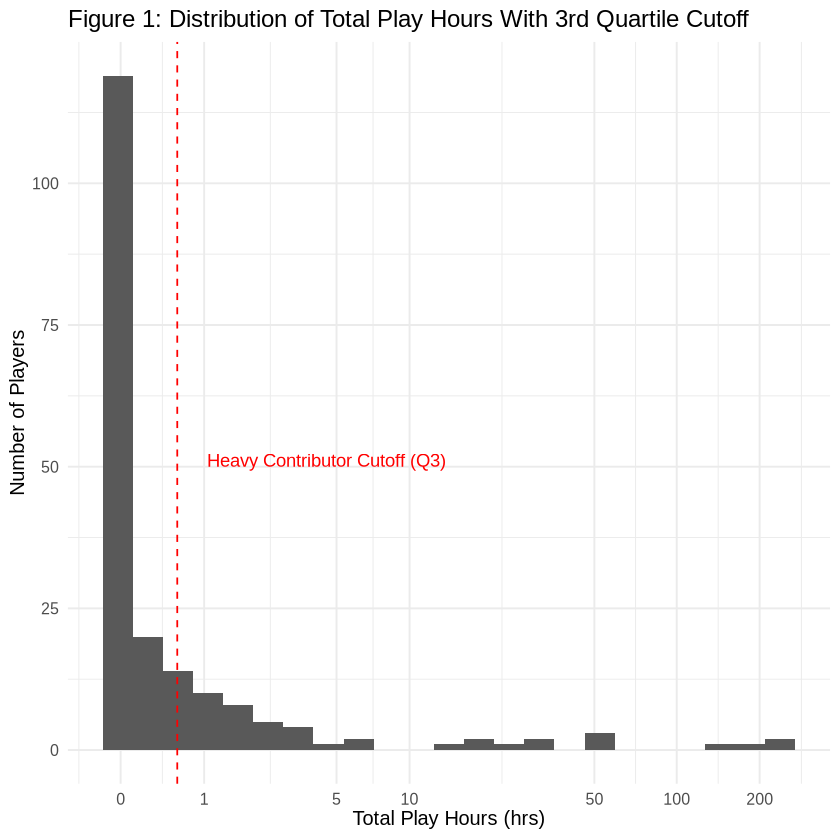

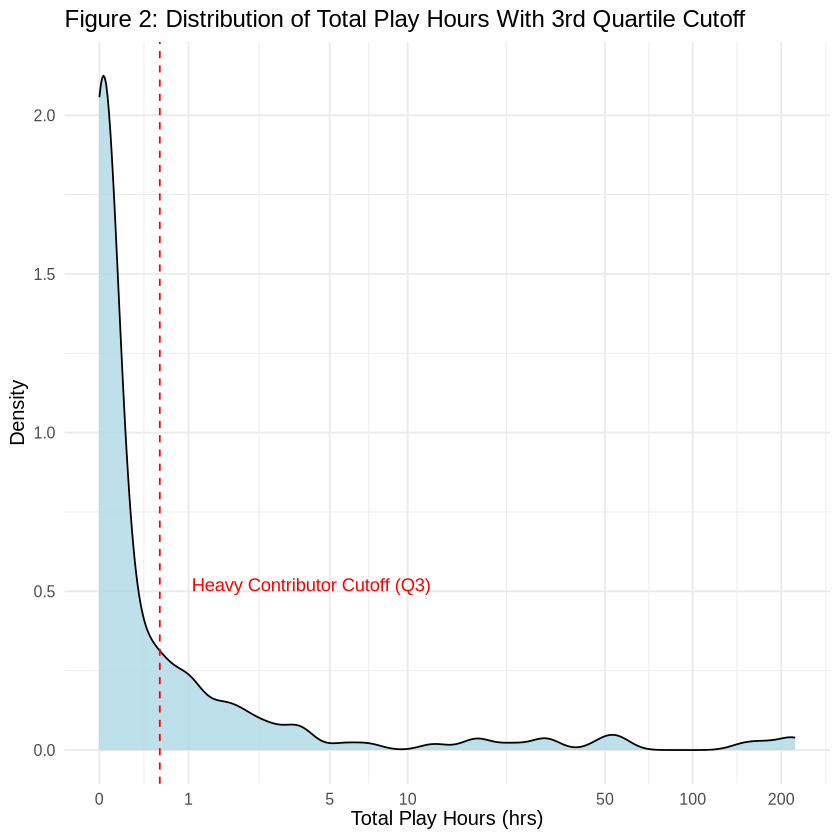

In [11]:
#the 75th percentile is about 0.6 hours = 26 minutes. (Q3)
quartile_3rd_cutoff <- players_data |>
    summarize(quartile_3rd = quantile(played_hours, 0.75, na.rm = TRUE)) |>
    pull(quartile_3rd)

# quartile_3rd_cutoff 

players_data_heavy <- players_data |>
    mutate(heavy_contributor = factor(played_hours >= quartile_3rd_cutoff,
                                      levels = c(FALSE, TRUE),
                                      labels = c("No", "Yes")))

# players_data_heavy

## Before Removing Players With Zero (0) Hours PLayed.
# First Histogram - Figure 1
heavy_histogram <- players_data_heavy |>
    ggplot(aes(x = played_hours)) +
    geom_histogram(
        binwidth = 0.25, 
        boundary = quartile_3rd_cutoff, 
        closed = "left") +
    geom_vline(
        xintercept = quartile_3rd_cutoff, 
        linetype = "dashed", 
        color = "red") +
    scale_x_continuous(
        # used a log scale to manage the tail.
        trans = "log1p",
        breaks = c(0, 1, 5, 10, 50, 100, 200))+
    annotate(
        "text", x = 1.05, y = 50, 
        label = "Heavy Contributor Cutoff (Q3)",
        hjust = 0, vjust = 0, colour = "red") +
    labs(
        x = "Total Play Hours (hrs)",
        y = "Number of Players",
        title = "Figure 1: Distribution of Total Play Hours With 3rd Quartile Cutoff") +
    theme_minimal(base_size = 12)

# Second Histogram - Figure 2
heavy_density_plot <- players_data_heavy |>
    ggplot(aes(x = played_hours)) +
    geom_density(fill = "lightblue", alpha = 0.8) + 
    geom_vline(
        xintercept = quartile_3rd_cutoff,  
        linetype = "dashed",  
        color = "red") +
    scale_x_continuous(
        trans = "log1p",
        breaks = c(0, 1, 5, 10, 50, 100, 200)) +
    annotate(
        "text", x = 1.05, y = 0.5, 
        label = "Heavy Contributor Cutoff (Q3)",
        hjust = 0, vjust = 0, colour = "red") +
    labs(
        x = "Total Play Hours (hrs)",
        y = "Density",  
        title = "Figure 2: Distribution of Total Play Hours With 3rd Quartile Cutoff") +
    theme_minimal(base_size = 12)

heavy_histogram
heavy_density_plot


- These distribution graphs (histograph and density plot) demonstrate the current recruitment problem that is faced by the stakehodlers, the vast majorty of players contribute nothing or close to nothing in play time and only few players contribute heavly towards the experiment. 

- The graphs illustrate a need for solving this issue and bridging the gap by aiming to fill the breaks between the local contribution areas (bars) and flatten the huge 0-play time spike skewing the graph towards one end over the other.

- The graphs also prompt me to experiment with removing the players with 0 played hours and recreate the graph to further examine the potential relationships present. 

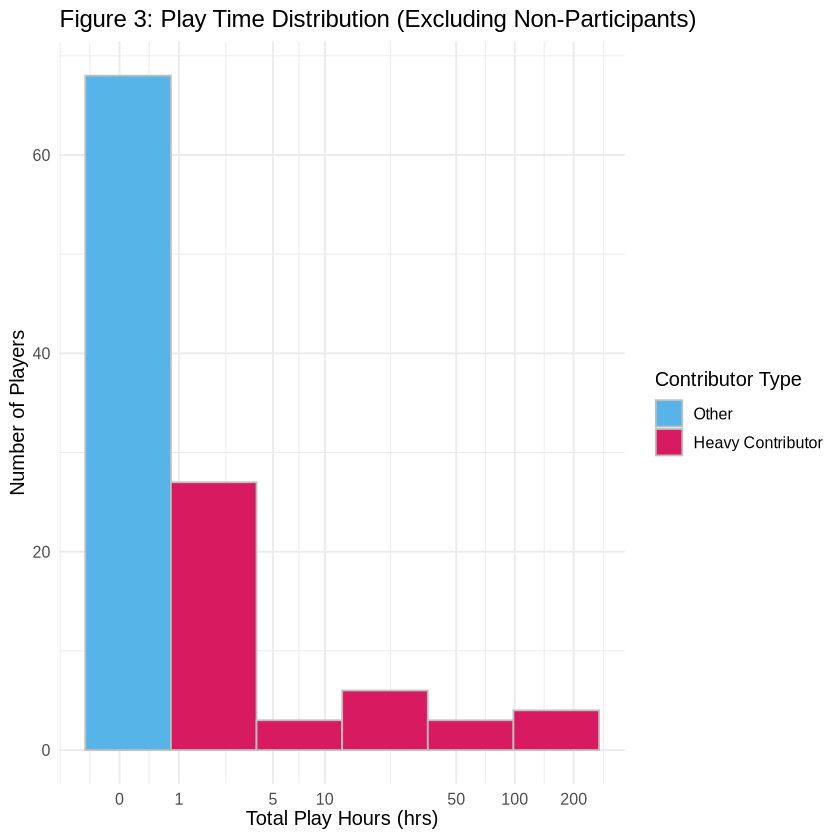

In [12]:
## After Removing Players With Zero (0) Hours PLayed.

# Players with 0 hours are removed:
players_data_0hrs_filtered <- players_data_heavy |>
    filter(played_hours > 0)

heavy_histogram_0hrs_removed <- players_data_0hrs_filtered |>
    ggplot(aes(x = played_hours)) +
    geom_histogram(
        aes(fill = after_stat(x >= quartile_3rd_cutoff)),
        binwidth = 1,
        boundary = quartile_3rd_cutoff,
        closed = "left",
        color = "grey"
        ) +
    scale_fill_manual(
        values = c("TRUE" = "#D81B60", "FALSE" = "#56B4E9"),
        labels = c("TRUE" = "Heavy Contributor", "FALSE" = "Other"),
        name = "Contributor Type"
        ) +
    scale_x_continuous(
        trans = "log1p",
        breaks = c(0, 1, 5, 10, 50, 100, 200)) +
    labs(
        x = "Total Play Hours (hrs)",
        y = "Number of Players", 
        title = "Figure 3: Play Time Distribution (Excluding Non-Participants)"
        ) +
    theme_minimal(base_size = 12)

heavy_histogram_0hrs_removed

#### Gender Category Regrouped

In [13]:
players_data_heavy <- players_data_heavy |>
  mutate(
    gender_group = case_when(
        gender == "Male"   ~ "Male",
        gender == "Female" ~ "Female",
        # then group everything else, basically!
        TRUE               ~ "Other"),
    gender_group = factor(gender_group,
                          levels = c("Male", "Female", "Other")))

# players_data_heavy

#### Heavy Contributors Share By Group

##### By Gender:-

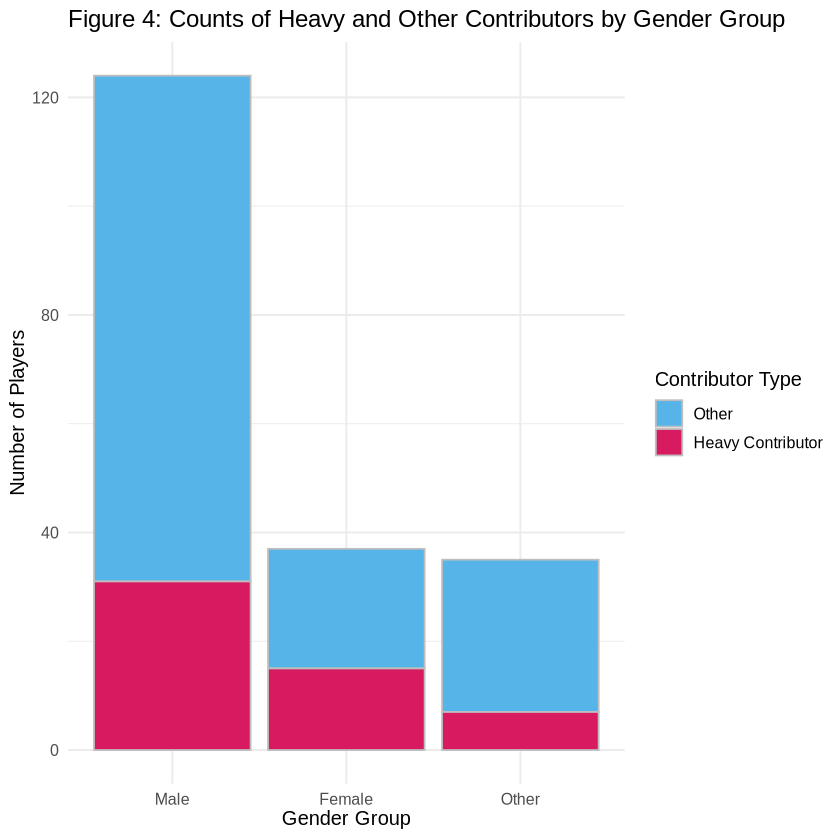

In [14]:


# Histogram:
# To Show The Distribution of Heavy Contributors in Each Gender Grouping
heavy_contributor_by_gender_histo <- players_data_heavy |>
  ggplot(aes(x = gender_group, fill = heavy_contributor)) +
  geom_bar(color = "grey") +
  scale_fill_manual(
    values = c("Yes" = "#D81B60", "No" = "#56B4E9"),
    labels = c("Yes" = "Heavy Contributor", "No" = "Other"),
    name   = "Contributor Type"
  ) +
  labs(
    x     = "Gender Group",
    y     = "Number of Players",
    title = "Figure 4: Counts of Heavy and Other Contributors by Gender Group"
  ) +
  theme_minimal(base_size = 12)

heavy_contributor_by_gender_histo


**Evlauting Hypothesis After Reading Figure 4:**

While the **male group has by far the largest number of players overall and the lasrgest number of heavy contribuors in raw counts**, both the female and 'other' gender groups seem to have fewer total players but still include a substaintial heavy contributors player base. While Figure 4 helps me **understand which gender group is the most represented amongst heavy contriubtors (male)** it prompts me to **invistage the share/percentage of heavy contributors within each gender group to obtain a normalized view and find potential conversion problems** in certain groups (to agjust for group size difference.) - This question is further investigated through the next figure (Figure 5) below.

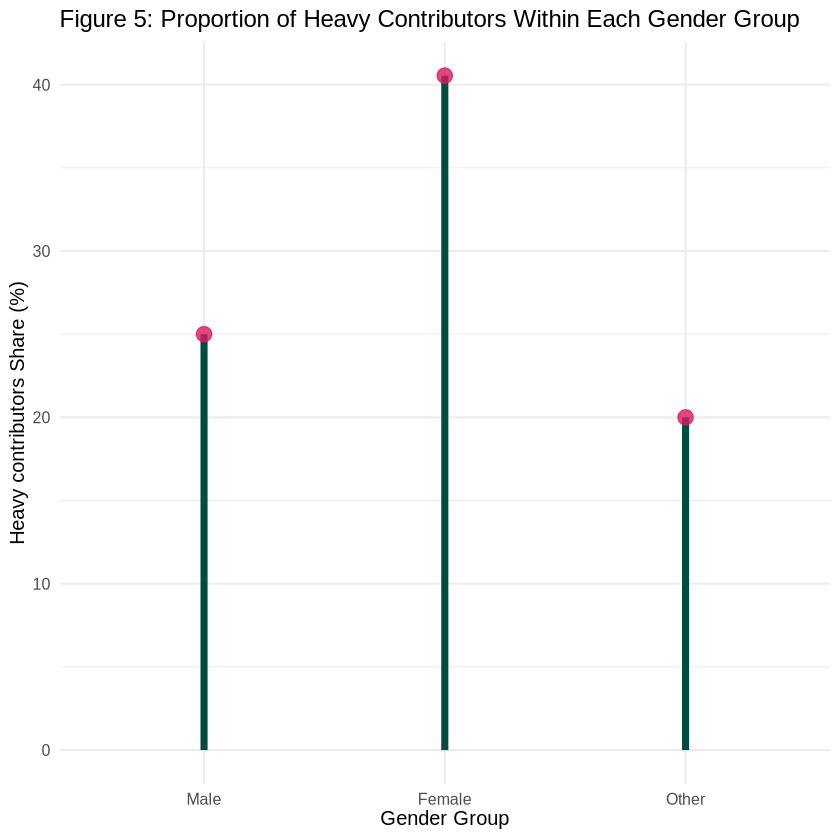

In [15]:
heavy_contributor_by_gender <- players_data_heavy |>
    group_by(gender_group) |>
    summarize(contributor_total = n(),
            heavy_total = sum(heavy_contributor == "Yes"),
            heavy_per = round(100 * heavy_total / contributor_total, 2),
            .groups = "drop")

# heavy_contributor_by_gender

# Lollipop Plot:
# To show each gender's heavy contributors' share.
heavy_contributor_by_gender_plot <- heavy_contributor_by_gender |>
    ggplot(aes(x = gender_group, y = heavy_per)) +
    geom_segment(aes(xend = gender_group, y = 0, yend = heavy_per),
                 color = "#004D40", linewidth = 2) +
    geom_point(alpha = 0.8, size = 4, color = "#D81B60") +
    labs(
        title = "Figure 5: Proportion of Heavy Contributors Within Each Gender Group",
        x = "Gender Group", 
        y = "Heavy contributors Share (%)"
        ) +
    theme_minimal(base_size = 12)

heavy_contributor_by_gender_plot

**Quality of Contribution per Demographic:**

Despite the fact that the female group has a smaller playerbase, **the female gender group has the hgihest percentage of heavy contributors**, while the 'other' gender group shows a lower percentage compared to both male and female groupings. This plot illustrates that **it is far more likely that a female is a heavy contributor**. This gives my investigation some hints around some *problematic or less than optimal recruitement, targetting, and sampling strategies*. 

##### By Experience:-

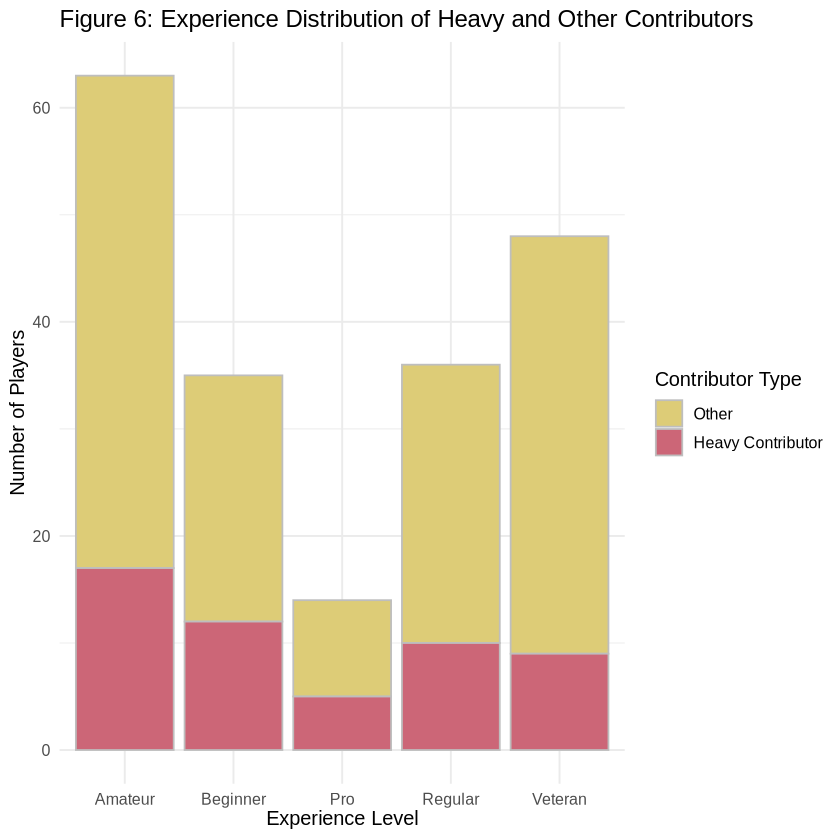

In [16]:
# Histogram
# Showing Experience Level vs Contribution 
heavy_contributor_by_experience_histo <- players_data_heavy |>
  ggplot(aes(x = experience, fill = heavy_contributor)) +
  geom_bar(color = "grey") +
  scale_fill_manual(
    values = c("Yes" = "#CC6677", "No" = "#DDCC77"),
    labels = c("Yes" = "Heavy Contributor", "No" = "Other"),
    name   = "Contributor Type"
      ) +
  labs(
    x     = "Experience Level",
    y     = "Number of Players",
    title = "Figure 6: Experience Distribution of Heavy and Other Contributors"
      ) +
  theme_minimal(base_size = 12)

heavy_contributor_by_experience_histo

**Composition of Contributors by Experience Level:**

While both amateur and vetern players dominate in terms of total numbers of players, there is a cleaer distinction when it comes to the number of heavy contributors. The plot shows us that **the largest heavy contributor player base is in the amateur subgroup** while the pro level contain the fewest number of heavy contributors. This suggests that the **largest pool of potential heavy contributors is within the amateur and vetern player bases**. Due to the fact that **recruitement resources are finite**, it might be better to focus on **precision rather than on recruiting volume**.

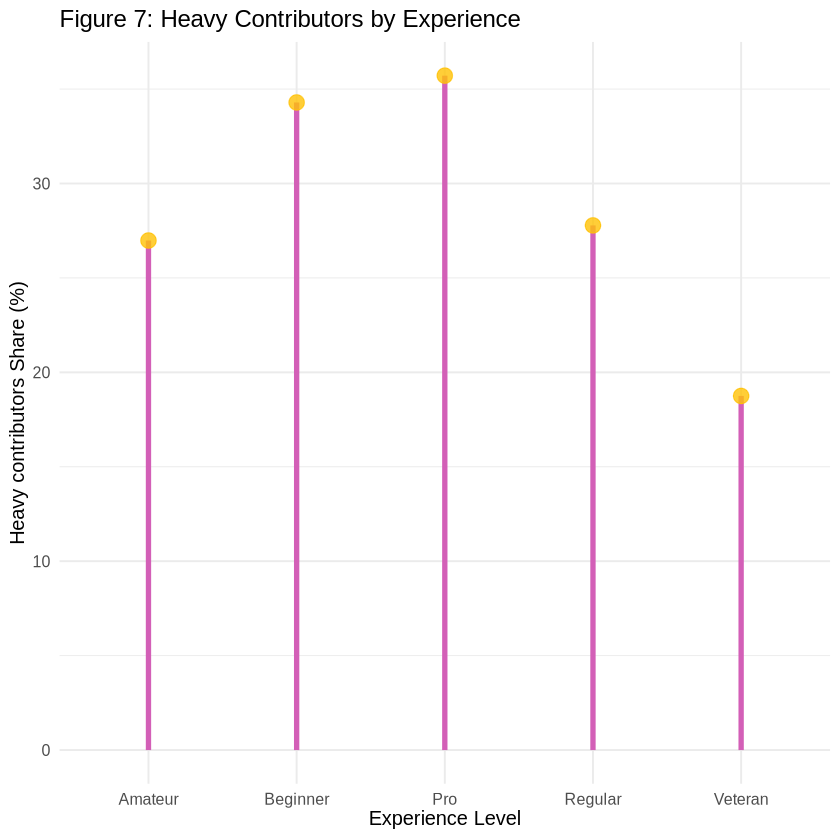

In [17]:
heavy_contributor_by_experience <- players_data_heavy |>
    group_by(experience) |>
    summarize(contributor_total = n(),
            heavy_total = sum(heavy_contributor == "Yes"),
            heavy_per = round(100 * heavy_total / contributor_total, 2),
            .groups = "drop")

# heavy_contributor_by_experience

heavy_contributor_by_experience_plot <- heavy_contributor_by_experience |>
    ggplot(aes(x = experience, y = heavy_per)) +
    geom_segment(aes(xend = experience, y = 0, yend = heavy_per),
                 color = "#D35FB7", linewidth = 1.5) +
    geom_point(alpha = 0.8, size = 4, color = "#FFC107") +
    labs(
        title = "Figure 7: Heavy Contributors by Experience ",
        x = "Experience Level", 
        y = "Heavy contributors Share (%)"
        ) +
    theme_minimal(base_size = 12)

heavy_contributor_by_experience_plot

**Share of Heavy Contributors Within Each Experience Level:**

Despite having the second largest player base, the vetern subgroup shows a relatively lower heavy contribtor share (the lowest amongst the 5 subgroups). **Pros have the hgihest conversion rate to heavy contribtion** despire being the smallest group in aboslute numbers. This makes total sense as one would hypothesize that pros tend to spend more time gaming and therefore, if they are interested enough to help with the experiment, they would contribute more to the project. As a pro's **behavioral profile** might suggest an innate motivation or goal-driven approach to playing the game and therefore aligning with **consistent and heavy participation**. This suggests that **experience as a proxy for a behavioral profile makes it helpful in predicting heavy contribution status**.

Furthermore, taking another look at the plot shows that suprisingly and maybe countering the logic of the analysis of Figure 7 in the previous paragraph, **the beginner subgroup shows a high heavy contribution share**. One potential idea is that this could be due to the **novelty factor or high spare time availability**. This suggests that the researchers might want to take a look at **cofounding variables**. 

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


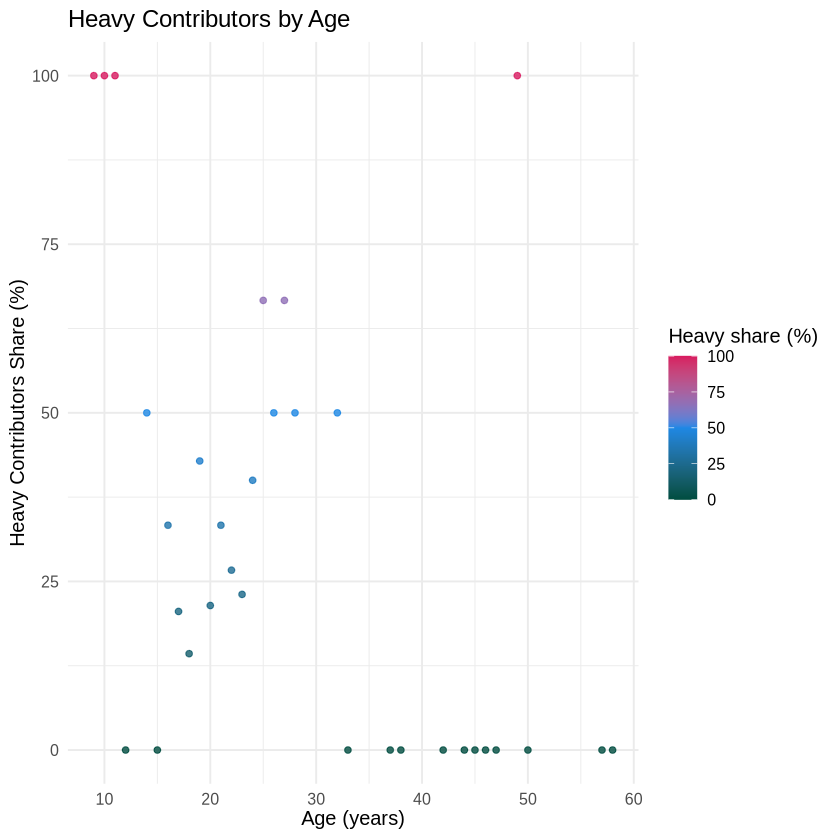

In [15]:

# By Age 
heavy_contributor_by_age <- players_data_heavy |>
    group_by(Age) |>
    summarize(contributor_total = n(),
            heavy_total = sum(heavy_contributor == "Yes"),
            heavy_per = round(100 * heavy_total / contributor_total, 2),
            .groups = "drop")

# heavy_contributor_by_age
# By Age Plot:
heavy_contributor_by_age_plot <- heavy_contributor_by_age |>
    ggplot(aes(x = Age, y = heavy_per, color = heavy_per)) +
    geom_point(alpha = 0.8) +
    labs(
        x = "Age (years)",
        y = "Heavy Contributors Share (%)",
        title = "Heavy Contributors by Age"
        ) +
    scale_color_gradientn(
        colors = c("#004D40", "#1E88E5", "#D81B60"),  # dark blue → blue → orange
        limits = c(0, 100),
        name = "Heavy share (%)"
        ) +
    theme_minimal(base_size = 12)

heavy_contributor_by_age_plot

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


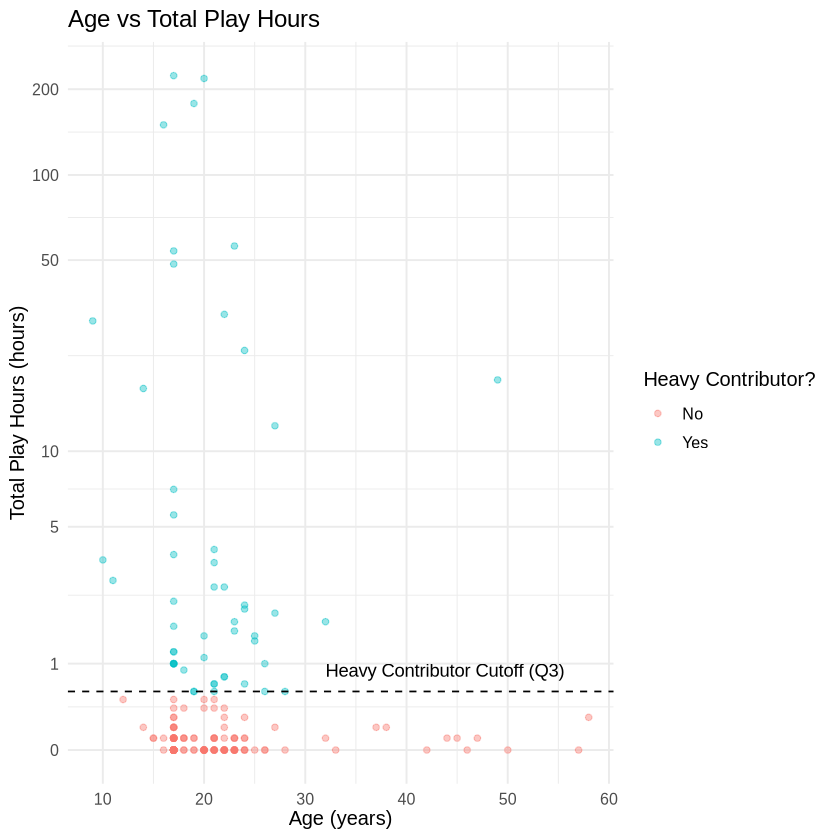

In [17]:
p3 <- ggplot(players_data_heavy, aes(x = Age, y = played_hours, color = heavy_contributor)) +
    geom_point(alpha = 0.4) +
    geom_hline(
        yintercept = quartile_3rd_cutoff,
        linetype = "dashed",
        color = "black") +
    scale_y_continuous(
        trans = "log1p",
        breaks = c(0,1,5,10,50,100,200)) +
    labs(
        title = "Age vs Total Play Hours",
        x = "Age (years)", 
        y = "Total Play Hours (hours)",
        color = "Heavy Contributor?") +
    annotate(
        "text", x = 32, y = 0.8, 
        label = "Heavy Contributor Cutoff (Q3)",
        hjust = 0, vjust = 0, colour = "black") +
    theme_minimal(base_size = 12)

p3

## Methods and Plan

I plan to use linear regression to predict whether a player is likely to be a heavy contributor (`heavy_contributor` = response variable) to the project or not, heavy contributor defined as a binary result with yes meaning that the player is in the top-quartile of played_hours, from the following explanatory variables:
1. `Age`
2. `experience`
3. `gender_group`

The method is approperiate to use because:
1. The prediction outcome is binary and can be expressed as a probability that certain characteristics of a player makes them a heavy contributor.
2. Linear regression handles the presence of much fewer data better than k-NN (which is more data hungry)
3.  

### Assumptions:

1. Each player is a separate unit (independent and tidy rows and variables). - we can check from the data descriptions section whether this is true or not
2. Proper linearity/scale for numeric predictors (we only have Age). - we can check by plotting/visually whether this numeric subset is skewed or not. 

### Limitations and Weaknesses:

1. Wide intervals and wrong estimates with very small groups, such as the gender category. This is the reason I proposed we merge less common gender levels to have "Male", "Female", and "Other" which will reduce uncertainty.
2. The model moght be more sensitive to outliers, in this data set, hypothetically if there is a player who is much older and is more experienced while at the same time putting more time in (heavy contributor) then the model might be influenced by this outlier and assume this on the path to a prediction.
3. Sensitivity to bias, in case of one subcategory 

### Porposed Data Processing and Model Application

##### from TA office hours: 
1. Why do them?
2. Think of you writting a paper with some code etc
3. Why would you do each of the preprocessing steps etc
4. Abstract part!
5. Check out the tutorial's answering method for cross-validation etc
6. For the reasoning you need to demonstrate EDA to the best ability. (digging into the value of the data, how might you approach the question through the reasoning and EDA etc).